## Solution 1: HRO in sklearn

### a)

Model classes representing a certain hypothesis are stored in subpackages of sklearn. You can reach it with importing the desired class with e.g.

In [1]:
#general
import numpy as np
import pandas as pd
import math
#plots
import matplotlib.pyplot as plt 
import seaborn as sns
#sklearn
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

It is good pratice to import everything in the beginning of your code.

You initialize your "learner" or model with its properties defined by the parameters, e.g.

In [2]:
model = LinearRegression(fit_intercept = True)
model

LinearRegression()

Before training them on actual data, they just contain information on the functional form of f. Once a learner has been trained we can examine the parameters of the resulting model. 

Optimization happens rather implicitly as sklearn only acts as a wrapper for existing implementations and calls package-specific optimization procedures within the function "model.fit()":

In [3]:
x = np.arange(0, 8, 0.01)
y = -1 + 3*x + np.random.normal(loc=0.0, scale=4, size=800)
model.fit(x.reshape(-1, 1),y) # reshape for one feature design matrix

LinearRegression()

The empirical risk can be assessed after training by several performance measures (e.g., based on L2 loss).

In [4]:
print('Model MSE: ', metrics.mean_squared_error(y,model.predict(x.reshape(-1, 1))))

Model MSE:  15.26613919907392


### b)

In [5]:
iris = load_iris() # function to import iris data set as type "utils.Bunch" with sklearn
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names
print("Type of object iris:", type(iris))
print("Feature names:", feature_names)
print("Target names:", target_names)
print("\nShape of X and y\n", X.shape, y.shape)
print("\nType of X and y\n", type(X), type(y))

Type of object iris: <class 'sklearn.utils._bunch.Bunch'>
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

Shape of X and y
 (150, 4) (150,)

Type of X and y
 <class 'numpy.ndarray'> <class 'numpy.ndarray'>


We obtain the following information:<br>
-  iris has categorical targets ['setosa' 'versicolor' 'virginica']
-  It has 150 observations of 5 variables, one of which is the target.
-  both, X and y, are of type 'numpy.ndarray', thus numerical. The 3 classes in target y are stored as numbers 0, 1, 2.

### c) 

sklearn offers many different models. Let's look at regression trees:

Roughly speaking, regression trees create small, homogeneous subsets (“nodes”) by repeatedly splitting the data at some cut-off (e.g., for iris: partition into observations with Sepal.Width ≤ 3 and > 3), and predict the mean target value within each final group. Regression trees are discussed in greater depth in chapter 06: Classification and Regression Trees (CART). This following demonstration rather aims at the general structure of a sklearn object.

In [6]:
# help(DecisionTreeRegressor) 

Prints documentary in console, or visit scikit-learn.org --> select right version --> go to right class, here sklearn.tree.DecisionTreeRegressor.

In [7]:
rtree = DecisionTreeRegressor() #default setting
print(rtree.get_params())
# print(rtree.get_depth()) # not working because no tree was fitted yet
# print(rtree.get_n_leaves()) # not working because no tree was fitted yet

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In general: DecisionTreeRegressor inherits from class sklearn.tree as it is used for regression, it predicts regression value for input X.

Important parameters <br>
criterion: choose between L2, L1, and others as Loss function <br>
splitter: strategy for choosing the split, default "best" <br>
max-depth: The maximum depth of the tree <br>
other complexity related params <br>
random_state: Controls the randomness of the estimator. To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer. 

## Solution 2: Loss Function for Regression Task

See sol_regression.pdf

## Solution 3: Polynomial Regression

### a) 

See sol_regression.pdf

### b) 


Choose 3 different parameterizations and plot the resulting polynomials:

In [8]:
x = np.linspace(-3,3, num = 60) # 3 included

In [9]:
def fun_y(x_in):
    """ 
    Method to produce named sinus function
    Input: data as numpy array
    Output: Function -3 + 5*sin(0.4 * pi * x_in) as numpy array
    """
    erg = -3 + 5* np.sin(0.4 * math.pi * x_in)
    return erg

def fun_poly3(x_in, beta):
    """ 
    Method to produce poynomial degree 3 with coefficents in numpy array beta for input data x_in
    Input: x_in as numpy array, beta as numpy array
    Output: function value as numpy array
    """  
    erg = beta[0] + beta[1] * x_in + beta[2] * x_in*x_in + beta[3] * x_in*x_in*x_in
    return erg

In [10]:
np.random.seed(43)
y = fun_y(x) + np.random.normal(size = 60)

In [11]:
poly3d = np.poly1d(np.polyfit(x,y,3)) # Polyfit function for polynomial functions
print(np.polyfit(x,y,3)) # coefficients

[-0.68708783 -0.04208217  4.60056399 -2.76629061]


Create plot from mathplotlib.pyplot

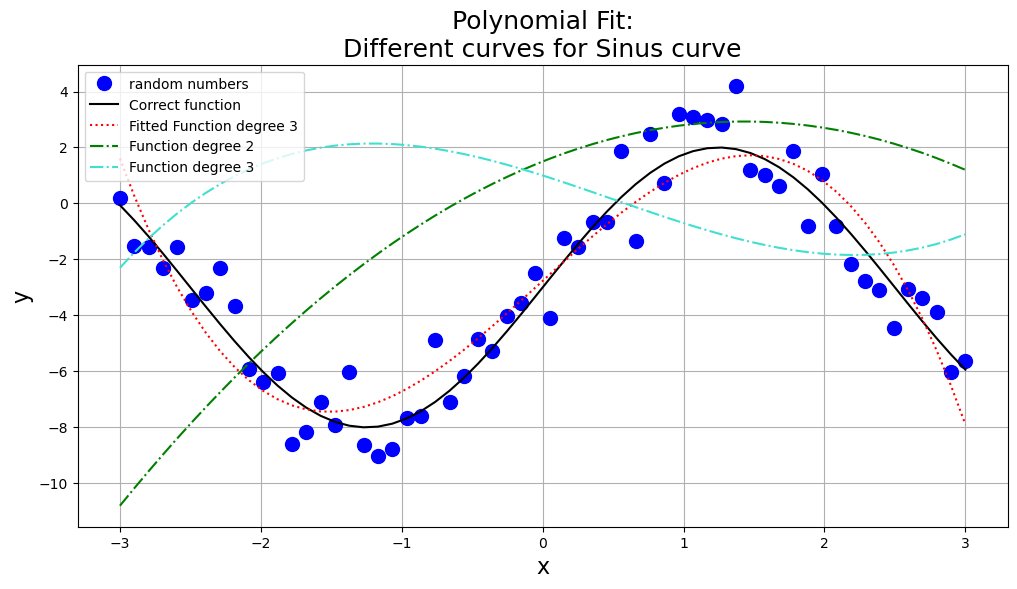

In [12]:
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(x, y, color='blue', linestyle='none',marker='o',markersize=10, label = 'random numbers')
plt.plot(x, fun_y(x), color='black', linestyle='solid', label = 'Correct function')
plt.plot(x, poly3d(x), color='red', linestyle='dotted', label = 'Fitted Function degree 3')
plt.plot(x, fun_poly3(x,np.array([1.5,2,-0.7,0])), color='green', linestyle='dashdot', label = 'Function degree 2')
plt.plot(x, fun_poly3(x,np.array([1,-1.6,-0.3,0.2])), color='turquoise', linestyle='dashdot', label = 'Function degree 3')
# title & label axes
plt.title('Polynomial Fit:\nDifferent curves for Sinus curve', size=18)
plt.xlabel('x', size=16)
plt.ylabel('y', size=16)
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

We see that our hypothesis space is simply a family of curves. The 3 examples plotted here already hint at the amount of flexibility third-degree polynomials offer over simple linear functions.

### c, d, e, f)

See sol_regression.pdf

## Solution 4: Predicting abalone

In [13]:
# Exercise 4 Prep: load data from url

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(url, sep=',', names=['sex', "longest_shell", "diameter", "height", "whole_weight", 
  "shucked_weight", "visceral_weight", "shell_weight", "rings"])

abalone = abalone[['longest_shell', 'whole_weight', 'rings']]
print(abalone.head)

<bound method NDFrame.head of       longest_shell  whole_weight  rings
0             0.455        0.5140     15
1             0.350        0.2255      7
2             0.530        0.6770      9
3             0.440        0.5160     10
4             0.330        0.2050      7
...             ...           ...    ...
4172          0.565        0.8870     11
4173          0.590        0.9660     10
4174          0.600        1.1760      9
4175          0.625        1.0945     10
4176          0.710        1.9485     12

[4177 rows x 3 columns]>


### a) 

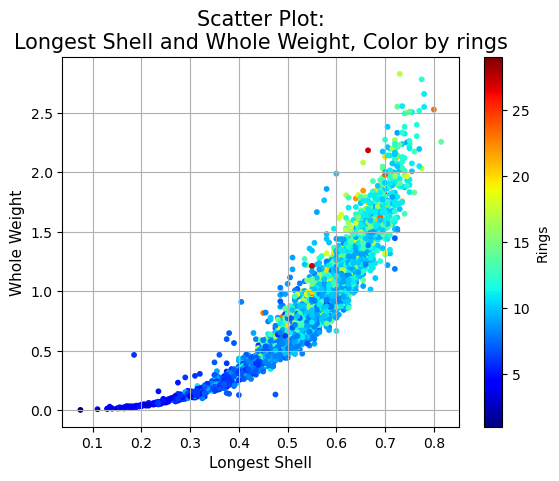

In [14]:
plt.grid(True)
plt.scatter(abalone.longest_shell, abalone.whole_weight, s=10, c= abalone.rings, cmap = 'jet') #choose appropriate color map
plt.colorbar(label = 'Rings') # add color bar
# title & label axes
plt.title('Scatter Plot:\nLongest Shell and Whole Weight, Color by rings', size=15)
plt.xlabel('Longest Shell', size=11)
plt.ylabel('Whole Weight', size=11)
plt.show()

We see that weight scales exponentially with shell length and that larger/heavier animals tend to have more rings.

### b) Fit Linear regression

In [15]:
X_lm = abalone.iloc[:, 0:2].values
y_lm = abalone.rings

lm = LinearRegression().fit(X_lm,y_lm)

pred_lm = lm.predict(X_lm)

results_dic = {'prediction' : pred_lm,
           'truth': y_lm}

results = pd.DataFrame(results_dic)

results.head()

,prediction,truth
0,8.840042,15
1,7.395659,7
2,9.821995,9
3,8.683616,10
4,7.160333,7


### c) 

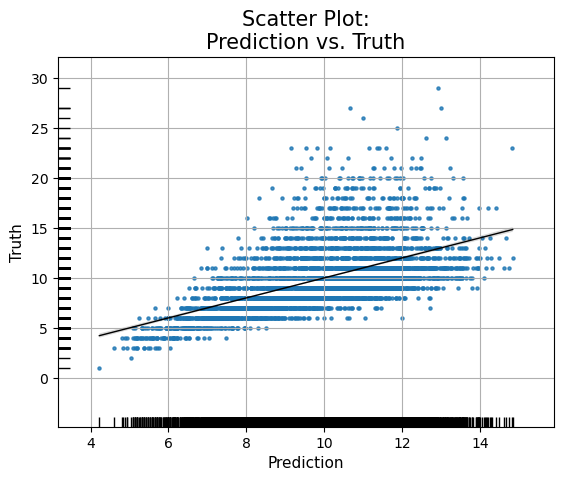

In [16]:
plt.grid(True)
#plt.scatter(pred_lm, y_lm, s=5) 
sns.regplot(x = pred_lm, y = y_lm, ci = 95, scatter_kws={'s':5}, line_kws={"color": "black", 'linewidth':1})
sns.rugplot(x = pred_lm, y = y_lm, height=0.025,  color='k')
# title & label axes
plt.title('Scatter Plot:\nPrediction vs. Truth', size=15)
plt.xlabel('Prediction', size=11)
plt.ylabel('Truth', size=11)
plt.show()

We see a scatterplot of prediction vs true values, where the small bars along the axes (a so-called rugplot) indicate the number of observations that fall into this area. As we might have suspected from the first plot, the underlying relationship is not exactly linear (ideally, all points and the resulting line should lie on the diagonal). With a linear model we tend to underestimate the response.

### d) 

In [17]:
#import function from sklearn
MAE = mean_absolute_error(pred_lm, y_lm)
print(MAE)

1.9506602873468448


### *)  Additional model assessing

There exists no R type regression summary report in sklearn. The main reason is that sklearn is used for predictive modelling / machine learning and the evaluation criteria are based on performance on previously unseen data (such as predictive r^2 for regression).

For the statistical view on Linear Regression you can use the package 

In [18]:
import statsmodels.formula.api as smf

The function OLS performs Ordinary least square fit (Linear regression) and has a summary() function. 

In [19]:
stats_lm = smf.ols('rings ~ longest_shell + whole_weight', data= abalone).fit()
stats_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rings   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     956.9
Date:                Tue, 28 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:54:54   Log-Likelihood:                -10028.
No. Observations:                4177   AIC:                         2.006e+04
Df Residuals:                    4174   BIC:                         2.008e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4313      0.316     10.873      0.000       2.813       4.050
longest_shell    10.5824      0.907     11.666      0.000       8.804      12.361
whole_weight      1.1550      0.222      5.200      0.000       0.720       1.591
==============================================================================
Omnibus:                     1380.300   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4440.751
Skew:                           1.687   Prob(JB):                         0.00
Kurtosis:                       6.759   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the summary function you can retrieve very easily the fitted coefficients and various model metrics based on the model itself and the training data.

Nevertheless, self-defined functions can be used for assessing models from sklearn:

In [20]:
def regression_results(y_true, y_pred):  
    """ 
    Method to produce model metrics for training data
    Input: training response vector as array, prediction vector as array
    Output: -
    """
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('Median Absolut Error: ', round(median_absolute_error,4))

In [21]:
regression_results(y_lm, pred_lm)

explained_variance:  0.3144
mean_squared_log_error:  0.0471
r2:  0.3144
MAE:  1.9507
MSE:  7.1255
RMSE:  2.6694
Median Absolut Error:  1.5254
